<header style="width:100%;position:relative">
  <div style="width:80%;float:right;">
    <h1>Challenge Loan Approval Prediction in Pennsylvania</h1>
    <h3>Entrenamiento y evaluación de los modelos</h3>
    <h5>Grupo 2</h5>
  </div>
        <img style="width:15%;" src="./images/logo.jpg" alt="UPM" />
</header>

# Índice

1. [Importar librerias](#1.-Importar-librerias)
2. [Variables globales y funciones auxiliares](#2.-Variables-globales-y-funciones-auxiliares)
3. [Carga del dataframe](#3.-Carga-del-dataframe)
4. [Selección de las características](#4.-Seleccion-de-las-caracteristicas)
5. [Carga de los datos y división en entrenamiento y test](#5.-Carga-de-los-datos-y-division-en-entrenamiento-y-test)
6. [Modelos seleccionados](#6.-Modelos-seleccionados)
    * 6.1 [Introducción](#6.1-Introduccion)
    * 6.2 [Clasificador Random Forest](#6.2-Clasificador-Random-Forest)
    * 6.3 [Clasificador MLP](#6.3-Clasificador-MLP)
    * 6.4 [Clasificador KNN](#6.4-Clasificador-KNN)
7. [Exportar CSV](#7.-Exportar-CSV)
    * 7.1 [Clasificador Random Forest](#7.1-Clasificador-Random-Forest)
    * 7.2 [Clasificador MLP](#7.2-Clasificador-MLP)
    * 7.3 [Clasificador KNN](#7.3-Clasificador-KNN)

# 1. Importar librerias

In [5]:
# General import and load data
import pandas as pd
import numpy as np

# Resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Splitting
from sklearn.model_selection import train_test_split

# Estimators
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer, f1_score, recall_score, roc_curve, roc_auc_score

# Optimization
from sklearn.model_selection import GridSearchCV, PredefinedSplit

# Visualization
import matplotlib.pyplot as plt

# Time optimization
import time

print("Todas las librerias fueron correctamente importadas.")

Todas las librerias fueron correctamente importadas.


# 2. Variables globales y funciones auxiliares

Se fija un seed para todo el documento para fijar la aleatoriedad y así obtener resultados replicables.

In [8]:
seed = 42

Función utilizado para evaluar los distintos umbrales en la curva de ROC.

In [10]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Recall:', 1 - fpr[thresholds > threshold][-1])

Función utilizada para estandarizar los datos en función del caso de preprocesado escogido.

In [12]:
def standard_data(case, X):
    
    if case in {1, 3, 5}:
        prep = StandardScaler().fit(X)
        X_scaled = prep.transform(X)
        
    elif case in {2, 4, 6}:
        prep = ColumnTransformer([
            ('numericas', StandardScaler(), numeric_vars)
        ], remainder='passthrough').fit(X) 
        X_scaled = prep.transform(X) 
        
    else:
        raise ValueError("El valor de 'case' no es válido. Debe estar entre 1 y 6.")
    
    return X_scaled, prep

Función utilizada para muestrear los datos en función del caso de preprocesado escogido.

In [14]:
def resample_data(case, X, y, strategy_under, strategy_over, neighbors=5):
    
    if case in {1, 2}:
        ovsamp = SMOTE(sampling_strategy=strategy_over, k_neighbors=neighbors, random_state=seed)
        X_resampled, y_resampled = ovsamp.fit_resample(X, y)
        
    elif case in {3, 4}:
        unsamp = RandomUnderSampler(sampling_strategy=strategy_under, random_state=seed)
        X_resampled, y_resampled = unsamp.fit_resample(X, y)
        
    elif case in {5, 6}:
        unsamp = RandomUnderSampler(sampling_strategy=strategy_under, random_state=seed)
        X_undersampled, y_undersampled = unsamp.fit_resample(X, y)
        ovsamp = SMOTE(sampling_strategy=strategy_over, k_neighbors=neighbors, random_state=seed)
        X_resampled, y_resampled = ovsamp.fit_resample(X_undersampled, y_undersampled)
        
    else:
        raise ValueError("El valor de 'case' no es válido. Debe estar entre 1 y 6.")
    
    return X_resampled, y_resampled

# 3. Carga del dataframe

Se cargan los datos de la ruta *formated/train_exportado.csv*, los cuales son los datos ya procesados por uno de nuestros compañeros.

In [17]:
url = "formated/train_exportado.csv"
df = pd.read_csv(url)

print("Datos cargados correctamente\n")

Datos cargados correctamente



También cargamos el test que debemos predecir para Kaggle de la ruta *formated/test_exportado.csv*.

In [19]:
url = "formated/test_exportado.csv"
df_test = pd.read_csv(url)

print("Test cargado correctamente\n")

Test cargado correctamente



# 4. Seleccion de las caracteristicas

Se seleccionan todas las características a excepción de las categoricas sin codificadar, al ya tener la misma információn codificada.

In [22]:
selected_features = [
    # Caracteristicas numericas
    'ApprovalFY', 'NoEmp', 'CreateJob', 'RetainedJob', 'DisbursementGross',

    # Caracteristicas categoricas binarias
    'NewExist_Binary', 'Franchise_Binary', 'UrbanRural_Binary',
    'RevLineCr_Binary', 'LowDoc_Binary', 'CreateJob_Binary',
    'RetainedJob_Binary',

    # Caracteristicas categoricas codificadas
    'Bank_Categorized_cod', 'BankState_Categorized_cod',
    'ApprovalFY_Grouped_cod', 'NoEmp_Grouped_cod', 
    'DisbursementGross_Grouped_cod',

     # Time-related features
    'ApprovalDate_quarter', 'DisbursementDate_quarter',

    # Caracteristicas relacionadas con BankState_Categorized tras un One Hot Encoding
    'BankState_DE', 'BankState_IL', 'BankState_OH', 
    'BankState_Otros', 'BankState_RI'
]

De las cuales, numéricas son las siguientes:

In [24]:
numeric_vars = ['ApprovalFY', 'NoEmp', 'CreateJob', 'RetainedJob', 'DisbursementGross']

# 5. Carga de los datos y division en entrenamiento y test

Cargamos las caracteristicas seleccionadas en la variable X y el objetivo *Accept* en la variable y.

In [27]:
X = df[selected_features] 
y = df['Accept'].values

Se separa ya en entrenamiento y test para no falsear los datos del test al realizar el balanceo.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

A la hora de subir el modelo a Kaggle, ya se nos da dividido el entrenamiento y el test. Por ello, se utilizarán todos los datos tratados como entrenamiento (aunque también se le aplicará el mejor caso de preprocesado para cada modelo).

In [31]:
X_train_final = X
y_train_final = y

X_test_final = df_test[selected_features] 

# 6. Modelos seleccionados

## 6.1 Introduccion

En el anterior notebook se evaluaron 10 modelos tanto por F1 score como por ROC-AUC score. Los resultados de mayor a menor de los modelos respecto a la F1-Score fueron los siguientes:
* Random Forest: 0.867449
* MLP: 0.811513
* DecisionTree: 0.790538
* KNN: 0.767966
* LinearSVC: 0.664541
* LogReg: 0.663316
* SVC_sigmoid: 0.617281
* GaussianNB: 0.568654
* SVC_poly: 0.526099
* SVC_rbf: 0.411304

En cambio, los resultados de mayor a menor de los modelos respecto a la ROC-AUC Score fueron los siguientes:
* Random Forest: 0.934825
* MLP: 0.884770
* KNN: 0.874725
* DecisionTree: 0.795805
* LinearSVC: 0.715244
* LogReg: 0.715162
* GaussianNB: 0.705878
* SVC_rbf: 0.692410
* SVC_poly: 0.658396
* SVC_sigmoid: 0.556961

Se decidió entrenar y optimizar los hiperparámetros de cuatro modelos. Los modelos escogidos fueron Random Forest, MLP, KNN y LinearSVC, es decir, los cuatro primeros tanto por F1-score como por ROC-AUC score (se ha excluido Decision Tree por ya estar probando un clasificador basado en árbol de decisión, y en un principio mejor).

## 6.2 Clasificador Random Forest

### 6.2.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [39]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 4

Hiperparametros base para cada caso.

In [41]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.8
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.25
    strategy_over = 0.5
    neighbors = 5

Se estandarizan los datos en función del caso.

In [43]:
X_scaled, prep = standard_data(case, X_train)

Se muestrean los datos en función del caso.

In [45]:
X_resampled, y_resampled = resample_data(case, X_scaled, y_train, strategy_under, strategy_over, neighbors)

Se reducen las dimensionalidades mediante un *PCA*.

In [47]:
pca = PCA()
X_pca_full = pca.fit_transform(X_resampled)

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
n_comp = np.argmax(cumulative_variance_ratio >= 0.95) + 1
X_pca = X_pca_full[:, :n_comp]

Al igual que se ha realizado distintos preprocesados al entrenamiento, hay que realizarlos al conjunto de test para obtener resultados coherentes.

No es necesario realizar las tecnicas de muestreo ya que eso son técnicas para balancear nuestro conjunto de entrenamiento. Solamente es necesario realizar la misma estandarización de las características y aplicar la misma reducción de dimensionalidad.

In [49]:
X_test_scaled = prep.transform(X_test)
X_test_pca_full = pca.transform(X_test_scaled)
X_test_pca = X_test_pca_full[:, :n_comp]

### 6.2.2 Definicion

Definimos el modelo con los hiperparámetros *random_state* fijado y *class_weigth* balanceado. También se escoje *n_jobs* con valor -1 para utilizar todos los procesadores.

In [52]:
model_Forest = RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=seed)

### 6.2.3 Entrenamiento y evaluacion

Entrenamos el modelo y comprobamos su exactitud.

In [55]:
model_Forest.fit(X_pca, y_resampled)

predicted_Forest = model_Forest.predict(X_test_pca)
expected_Forest = y_test

In [56]:
accuracy_score(expected_Forest, predicted_Forest)

0.7339977851605759

### 6.2.4 Null accuracy

Ahora se va a evaluar si  el modelo siempre predice la clase más frecuente.

In [59]:
s_y_test = pd.Series(y_test)
s_y_test.value_counts()

1    3765
0     750
Name: count, dtype: int64

In [60]:
y_test.mean()

0.8338870431893688

In [61]:
1 - y_test.mean() 

0.1661129568106312

In [62]:
max(y_test.mean(), 1 - y_test.mean())

0.8338870431893688

In [63]:
s_y_test.value_counts().head(1) / len(y_test)

1    0.833887
Name: count, dtype: float64

Nuestra exactitud es de 0.733, la cual es peor que la *null accuracy*, es decir, ahora mismo no tenemos un buen modelo ya que se predecirían un mayor número de resultados en el caso de siempre predecir la clase mayoritaria.

### 6.2.5 Matriz de confusion y F-score

Se muestra la matriz de confusión y el informe de clasificación.

In [67]:
print(confusion_matrix(expected_Forest, predicted_Forest))

[[ 443  307]
 [ 894 2871]]


In [68]:
print(classification_report(expected_Forest, predicted_Forest))

              precision    recall  f1-score   support

           0       0.33      0.59      0.42       750
           1       0.90      0.76      0.83      3765

    accuracy                           0.73      4515
   macro avg       0.62      0.68      0.63      4515
weighted avg       0.81      0.73      0.76      4515



Se observa lo que hemos estado comentando durante todo el documento, tenemos un f1-score del 0.83 para los 1s mientras que estamos obteniendo un 0.42 para los 0s

### 6.2.6 ROC y AUC

Evaluamos la ROC-AUC score. Para ello representamos primero la curva de ROC.

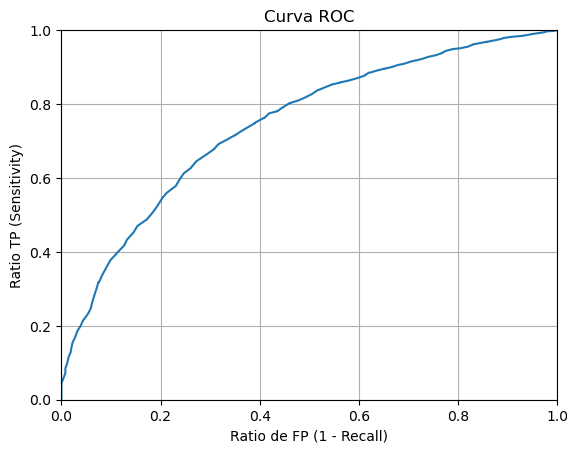

In [72]:
y_pred_prob_Forest = model_Forest.predict_proba(X_test_pca)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_Forest)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC')
plt.xlabel('Ratio de FP (1 - Recall)')
plt.ylabel('Ratio TP (Sensitivity)')
plt.grid(True)
plt.show()

Y mostramos sus thresholds.

In [74]:
thresholds

array([       inf, 1.        , 0.99      , 0.98      , 0.97      ,
       0.96      , 0.95      , 0.94      , 0.93      , 0.92      ,
       0.91      , 0.9       , 0.89      , 0.88      , 0.87      ,
       0.86      , 0.85      , 0.84      , 0.83      , 0.82285741,
       0.82      , 0.81285741, 0.81      , 0.80444477, 0.8       ,
       0.79      , 0.78      , 0.77174295, 0.77      , 0.75      ,
       0.74717085, 0.74      , 0.73285741, 0.73      , 0.72      ,
       0.71666696, 0.71      , 0.70447303, 0.7       , 0.69      ,
       0.68      , 0.67137947, 0.67      , 0.66888954, 0.66      ,
       0.65285741, 0.65      , 0.64615416, 0.64      , 0.63      ,
       0.62444477, 0.62      , 0.61      , 0.60102576, 0.6       ,
       0.59615416, 0.59      , 0.58444477, 0.58      , 0.57494895,
       0.57      , 0.56494895, 0.56      , 0.55      , 0.54330738,
       0.54166685, 0.54      , 0.53      , 0.52      , 0.51375031,
       0.51      , 0.50912118, 0.50721869, 0.5       , 0.49347

Sorprendentemente, el modelo muestra un mejor rendimiento del esperado, aunque se aboserva la situación con los 0s al aumentar más rápido el eje *x* respecto al eje *y*.

La siguiente gráfica muestra las probabilidades de predicción en función de los umbrales.

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

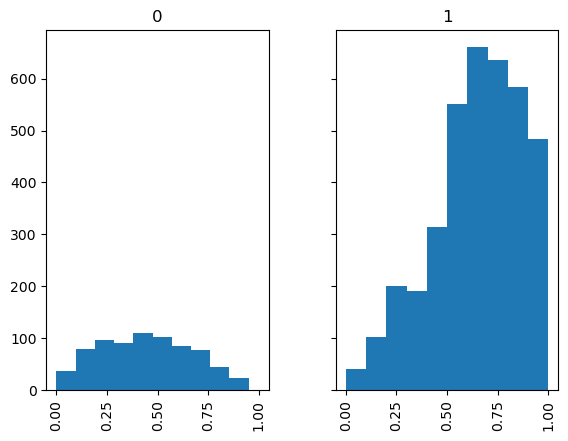

In [77]:
dprob = pd.DataFrame(data = {'probability':y_pred_prob_Forest, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

Se muestra que los mejores resultados para ambas clases se obtiene con el *threshold* igual a 0.75.

In [79]:
best_thres_Random = 0.4

evaluate_threshold(best_thres_Random)

Sensitivity: 0.8523240371845949
Recall: 0.45599999999999996


Con este valor se obtienen los siguientes resultados. Primero se recalculan las predicciones.

In [81]:
probs_Forest = model_Forest.predict_proba(X_test_pca)[:, 1]  
pred_thres_Forest = (probs_Forest >= best_thres_Random).astype(int) 

Se evalua la matriz de confusión.

In [83]:
print(confusion_matrix(expected_Forest, pred_thres_Forest))

[[ 329  421]
 [ 535 3230]]


Y también se analiza el informe de la clasificación.

In [85]:
print(classification_report(expected_Forest, pred_thres_Forest))

              precision    recall  f1-score   support

           0       0.38      0.44      0.41       750
           1       0.88      0.86      0.87      3765

    accuracy                           0.79      4515
   macro avg       0.63      0.65      0.64      4515
weighted avg       0.80      0.79      0.79      4515



Es decir, se obtiene una mejora significatica de la exactitud, a costa de empeorar 0.01 en la f1-score de los 0s.

Finalmente se calcula el valor de AUC.

In [88]:
print(roc_auc_score(expected_Forest, predicted_Forest))

0.6766082337317396


Se ha obtenido un valor entre 0.6 y 0.7, es decir, el modelo se considerá como pobre o *D*.

### 6.2.7 Optimizacion

Antes de nada, observamos cuales son los parámetros de nuestro modelo.

In [92]:
model_Forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

También creemos que es interesante saber la profundidad media de nuestro modelo Random Forest, para así poder estimar mejor rango de valores en este apartado.

In [94]:
arboles_decision = model_Forest.estimators_

profundidades = [arbol.tree_.max_depth for arbol in arboles_decision]
profundidad_media = np.mean(profundidades)

print(f"Profundidad media de los árboles: {profundidad_media}")

Profundidad media de los árboles: 29.21


Ahora seleccionamos los hiperparámetros a evaluar mediante un GridSearchCV. Como se evalua mediante un *cross validation*, siempre escogeremos los casos 3 o 4 de preprocesado para falsear menos los datos. Además, se ha añadido la librería *time* para saber el tiempo que tardo en realizar la busqueda de mejores parámetros.

Estos hiperparámetros son:
* n_estimator: número de árboles.
* criterion: función para medir la calidad de una partición.
* max_depth: máxima profundidad de cada árbol.
* min_samples_split: número de muestras mínimas para dividir un nodo interno.
* min_samples_leaf: número de muestras mínimas de un nodo hoja.
* max_features: número de características a tener en cuenta a la hora de buscar la mejor división.
* class_weight: pesos asignados a las clases.

Se calcula el tiempo que ha tardado en minutos.

Se escoge el mejor parámetro y su  precisión asociada.

Observamos los mejores 10 casos para analizar varias posibilidades.

### 6.2.8 Entramiento y evaluacion con hiperparametros optimizados

#### - Definicion

Definimos los mejores parámetros (no se define con *grid_search.best_params_* para probar varias opciones de forma sencilla).

In [102]:
params_final_Forest = {
    'class_weight': 'balanced_subsample',
    'max_depth': 25,
    'max_features': 4,
    'min_samples_leaf': 4,
    'min_samples_split': 2,
    'n_estimators': 300,
    'n_jobs': -1,
    'random_state': seed
}

Definimos el modelo desagregando el diccionario.

In [104]:
final_Forest = RandomForestClassifier(**params_final_Forest)

#### - Entrenamiento y evaluacion

Entrenamos el modelo y comprobamos su exactitud.

In [107]:
final_Forest.fit(X_pca, y_resampled)

predicted_For_opt = final_Forest.predict(X_test_pca)
expected_For_opt = y_test

In [108]:
accuracy_score(expected_For_opt, predicted_For_opt)

0.7260243632336656

#### - Null accuracy

La accuracy es similar a la anterior. Además, sigue siendo peor que la *null accuracy*.

#### - Matriz de confusion y F-score

La matriz de confusión y el informe de clasificación también es muy similar.

In [113]:
print(confusion_matrix(expected_For_opt, predicted_For_opt))

[[ 467  283]
 [ 954 2811]]


In [114]:
print(classification_report(expected_For_opt, predicted_For_opt))

              precision    recall  f1-score   support

           0       0.33      0.62      0.43       750
           1       0.91      0.75      0.82      3765

    accuracy                           0.73      4515
   macro avg       0.62      0.68      0.62      4515
weighted avg       0.81      0.73      0.75      4515



#### - ROC y AUC

Se calcula el ROC y se reajusta el umbral de probabilidad.

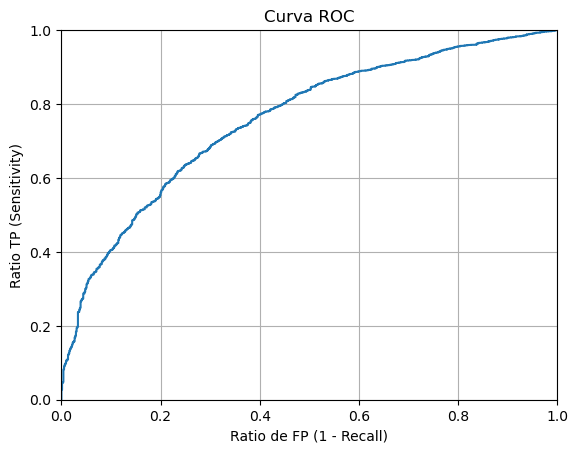

In [117]:
y_pred_prob_Forest = final_Forest.predict_proba(X_test_pca)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_Forest)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC')
plt.xlabel('Ratio de FP (1 - Recall)')
plt.ylabel('Ratio TP (Sensitivity)')
plt.grid(True)
plt.show()

In [118]:
thresholds

array([       inf, 0.99637653, 0.97221666, ..., 0.03552526, 0.02568752,
       0.01293869])

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

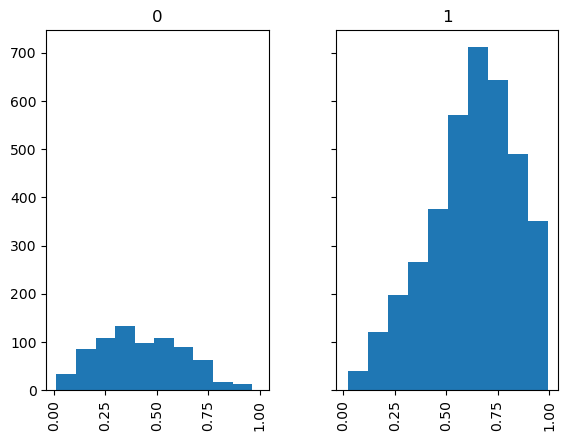

In [119]:
dprob = pd.DataFrame(data = {'probability':y_pred_prob_Forest, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

In [120]:
op_thres_Random = 0.35

evaluate_threshold(op_thres_Random)

Sensitivity: 0.8889774236387782
Recall: 0.396


In [121]:
probs_For_opt = final_Forest.predict_proba(X_test_pca)[:, 1]  
pred_thres_For_opt = (probs_For_opt >= op_thres_Random).astype(int) 

In [122]:
print(confusion_matrix(expected_For_opt, pred_thres_For_opt))

[[ 297  453]
 [ 417 3348]]


In [123]:
print(classification_report(expected_For_opt, pred_thres_For_opt))

              precision    recall  f1-score   support

           0       0.42      0.40      0.41       750
           1       0.88      0.89      0.89      3765

    accuracy                           0.81      4515
   macro avg       0.65      0.64      0.65      4515
weighted avg       0.80      0.81      0.81      4515



Se obtiene la misma accuracy aunque mejora la *f1 score* en los 0s.

Se calcula la AUC score.

In [126]:
print(roc_auc_score(expected_For_opt, predicted_For_opt))

0.6846401062416999


También ha tenido una pequeña mejora, pero sigue en el mismo intervalo. Es decir, sigue siendo un modelo *D*.

### 6.2.9 Conclusiones

A continuación se muestra los resultados de los modelos optimizados y sin optimizar. Cabe recalcar que se probaron otros cuatro conjuntos de hiperparámetros para la mayoria de los casos de preprocesado, pero se acabó considerando absurdo porque mejoraba o empeoraba 0.01 en diversos valores.

Caso X: accuracy - f1 score 0s - aux score - accuracy y f1 score 0s (threshold)

Caso 1: 
* Normal:      0.78 - 0.35 - 0.612 - 0.75 y 0,38 (0.6)
* Optimizado:  0.78 - 0.40 - 0.642 - 0.78 y 0.40 (0.5)

Caso 2: 
* Normal:      0.78 - 0.38 - 0.627 - 0.75 y 0,40 (0.6)
* Optimizado:  0.77 - 0.40 - 0.645 - 0.77 y 0.40 (0.5)

Caso 3:
* Normal:      0.72 - 0.41 - 0.666 - 0.78 y 0,41 (0.4)
* Optimizado:  0.72 - 0.43 - 0.689 - 0.80 y 0.40 (0.35)

Caso 4: 
* Normal:      0.73 - 0.42 - 0.676 - 0.79 y 0,41 (0.4)
* Optimizado:  0.73 - 0.43 - 0.684 - 0.81 y 0.41 (0.35)

Caso 5: 
* Normal:      0.80 - 0.34 - 0.602 - 0.78 y 0,37 (0.6)
* Optimizado:  0.79 - 0.38 - 0.632 - 0.77 y 0.40 (0.55)

Caso 6: 
* Normal:      0.81 - 0.37 - 0.619 - 0.78 y 0,39 (0.6)
* Optimizado:  0.78 - 0.40 - 0.684 - 0.76 y 0.41 (0.55)

Caso 3-2 (undersampling = 0.6): 
* Normal:      0.77 - 0.40 - 0.664 - 0.78 y 0,41 (0.4)
* Optimizado:  0.72 - 0.43 - 0.689 - 0.79 y 0.40 (0.4)

Caso 4-2 (undersampling = 0.6):
* Normal:      0.78 - 0.42 - 0.664 - 0.80 y 0,40 (0.45)
* Optimizado:  0.75 - 0.42 - 0.670 - 0.80 y 0.42 (0.4)

Caso 5-2 (undersampling = 0.6 y oversampling = 0.8): 
* Normal:      0.75 - 0.40 - 0.651 - 0.80 y 0,39 (0.4)
* Optimizado:  0.74 - 0.42 - 0.672 - 0.79 y 0.41 (0.55)

Caso 6-2 (undersampling = 0.6 y oversampling = 0.8): 
* Normal:      0.75 - 0.41 - 0.659 - 0.78 y 0,41 (0.45)
* Optimizado:  0.74 - 0.43 - 0.676 - 0.81 y 0.39 (0.35)

Se observa que para este modelo todos son valores muy similares. Por ello se probará primero a la hora de subirlo con el caso mejor (el cuatro) pero también se realizarán pruebas sobre Kaggle con el resto.

## 6.3 Clasificador MLP

### 6.3.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [135]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 6

Hiperparametros base para cada caso.

In [137]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.8
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.25
    strategy_over = 0.5
    neighbors = 5

Se estandarizan los datos en función del caso.

In [139]:
X_scaled, prep = standard_data(case, X_train)

Se muestrean los datos en función del caso.

In [141]:
X_resampled, y_resampled = resample_data(case, X_scaled, y_train, strategy_under, strategy_over, neighbors)

Se reducen las dimensionalidades mediante un *PCA*.

In [143]:
pca = PCA()
X_pca_full = pca.fit_transform(X_resampled)

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
n_comp = np.argmax(cumulative_variance_ratio >= 0.95) + 1
X_pca = X_pca_full[:, :n_comp]

Al igual que se ha realizado distintos preprocesados al entrenamiento, hay que realizarlos al conjunto de test para obtener resultados coherentes.

No es necesario realizar las tecnicas de muestreo ya que eso son técnicas para balancear nuestro conjunto de entrenamiento. Solamente es necesario realizar la misma estandarización de las características y aplicar la misma reducción de dimensionalidad.

In [145]:
X_test_scaled = prep.transform(X_test)
X_test_pca_full = pca.transform(X_test_scaled)
X_test_pca = X_test_pca_full[:, :n_comp]

### 6.3.2 Definicion

Definimos el modelo con los hiperparámetros *random_state* fijado y *max_iter* con valor 1000. También se escoje *hidden_layer_sizes* con los mismos valores que en el notebook de evaluación de los modelos.

In [148]:
model_Mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=seed)

### 6.3.3 Entrenamiento y evaluacion

Entrenamos el modelo y comprobamos su exactitud.

In [151]:
model_Mlp.fit(X_pca, y_resampled)

predicted_Mlp = model_Mlp.predict(X_test_pca)
expected_Mlp = y_test

In [152]:
accuracy_score(expected_Mlp, predicted_Mlp)

0.7723145071982281

### 6.3.4 Null accuracy

Nuestra exactitud es de 0.772, la cual es peor que la *null accuracy*, es decir, ahora mismo no tenemos un buen modelo ya que se predecirían un mayor número de resultados en el caso de siempre predecir la clase mayoritaria.

### 6.3.5 Matriz de confusion y F-score

Se muestra la matriz de confusión y el informe de clasificación.

In [157]:
print(confusion_matrix(expected_Mlp, predicted_Mlp))

[[ 287  463]
 [ 565 3200]]


In [158]:
print(classification_report(expected_Mlp, predicted_Mlp))

              precision    recall  f1-score   support

           0       0.34      0.38      0.36       750
           1       0.87      0.85      0.86      3765

    accuracy                           0.77      4515
   macro avg       0.61      0.62      0.61      4515
weighted avg       0.78      0.77      0.78      4515



Se observa lo que hemos estado comentando durante todo el documento, tenemos un f1-score del 0.86 para los 1s mientras que estamos obteniendo un 0.36 para los 0s.

### 6.3.6 ROC y AUC

Evaluamos la ROC-AUC score. Para ello representamos primero la curva de ROC.

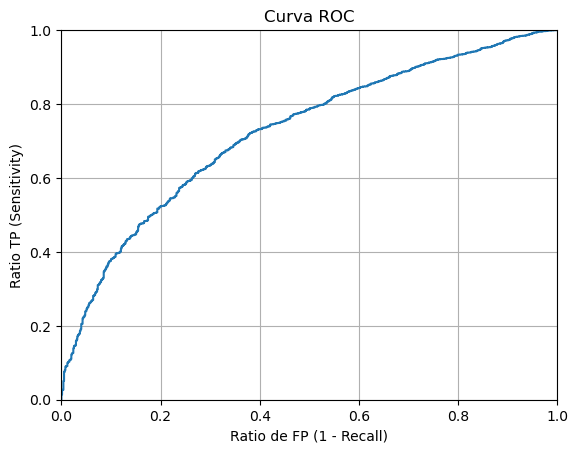

In [162]:
y_pred_prob_Mlp = model_Mlp.predict_proba(X_test_pca)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_Mlp)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC')
plt.xlabel('Ratio de FP (1 - Recall)')
plt.ylabel('Ratio TP (Sensitivity)')
plt.grid(True)
plt.show()

Y mostramos sus thresholds.

In [164]:
thresholds

array([           inf, 1.00000000e+00, 9.99999994e-01, ...,
       2.86136810e-03, 2.39364231e-03, 6.63029908e-06])

La siguiente gráfica muestra las probabilidades de predicción en función de los umbrales.

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

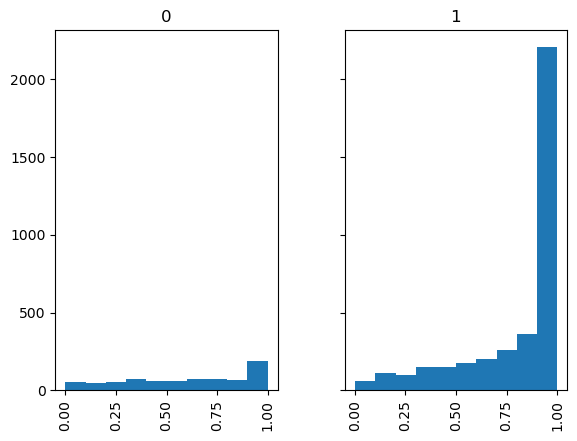

In [166]:
dprob = pd.DataFrame(data = {'probability':y_pred_prob_Mlp, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

Se muestra unos resultados muy balanceados en el 0s excepto cuando su threshold es 1, mientras que en el caso de los 1s mantiene una tendencia ascendente.

In [168]:
best_thres_Mlp = 0.4

evaluate_threshold(best_thres_Mlp)

Sensitivity: 0.8892430278884462
Recall: 0.30000000000000004


Con este valor se obtienen los siguientes resultados. Primero se recalculan las predicciones.

In [170]:
probs_Mlp = model_Mlp.predict_proba(X_test_pca)[:, 1]  
pred_thres_Mlp = (probs_Mlp >= best_thres_Mlp).astype(int) 

Se evalua la matriz de confusión.

In [172]:
print(confusion_matrix(expected_Mlp, pred_thres_Mlp))

[[ 225  525]
 [ 416 3349]]


Y también se analiza el informe de la clasificación.

In [174]:
print(classification_report(expected_Mlp, pred_thres_Mlp))

              precision    recall  f1-score   support

           0       0.35      0.30      0.32       750
           1       0.86      0.89      0.88      3765

    accuracy                           0.79      4515
   macro avg       0.61      0.59      0.60      4515
weighted avg       0.78      0.79      0.78      4515



Es decir, se empeora la exactitud a cambio de mejorar la f1-score de los 0s.

Finalmente se calcula el valor de AUC.

In [177]:
print(roc_auc_score(expected_Mlp, predicted_Mlp))

0.6163001328021249


Se ha obtenido un valor entre 0.6 y 0.7, es decir, el modelo se considerá como pobre o *D*.

### 6.3.7 Optimizacion

Antes de nada, observamos cuales son los parámetros de nuestro modelo.

In [181]:
model_Mlp.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100, 50),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 1000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

Para que el entrenamiento sea realista debemos activar el hiperparámetro *early_stopping* para que se detenga cuando el score de validación no está mejorando, independientemente del número de iteraciones introducidas. Adenás, con ello se dividirán nuestros datos por defecto en 90% entrenamiento y 10% validación. En el caso de querer aumentar más este porcentaje deberemos modificar el hiperparámetro *validation_fraction*.

Al entrenar el modelo de esta forma será estrictamente necesario fijarnos en los atributos *loss_curve_* y *validation_scores_* del modelo, los cuales deberán tener una tendencia decreciente y creciente respectivamente.

Ahora seleccionamos los hiperparámetros a evaluar mediante un GridSearchCV. Como la cantidad de registros es muy importante para las capas ocultas del MLP, se ha creado un PredefinedSplit para fijar los datos de entrenamiento y los de test.

Estos hiperparámetros son:
* hidden_layer_sizes: número de neuronas de cada capa oculta.
* activation: función de activación de las capas ocultas.
* solver: solver utilizado para la optimización de los pesos.
* alpha: fuerza del término de regularización L2.
* batch_size: tamaño de los minibatches para los optimizadores estocásticos.
* learning_rate: programa de la tasa de aprendizaje para la actualización de pesos.
* learning_rate_init: learning rate inicial.

Se calcula el tiempo que ha tardado en minutos.

Se escoge el mejor parámetro y su  precisión asociada.

Observamos los mejores 10 casos para analizar varias posibilidades.

### 6.3.8 Entramiento y evaluacion con hiperparametros optimizados

#### - Definicion

Definimos los mejores parámetros (no se define con *grid_search.best_params_* para probar varias opciones de forma sencilla).

In [191]:
params_final_Mlp = {
    'activation': 'relu', 
    'alpha': 0.01, 
    'batch_size': 400,
    'hidden_layer_sizes': (128, 64, 32), 
    'learning_rate': 'constant', 
    'learning_rate_init': 0.01, 
    'solver': 'sgd',
    'max_iter': 1000, 
    'early_stopping': True, 
    'validation_fraction': 0.15, 
    'random_state': seed
}

Definimos el modelo desagregando el diccionario.

In [193]:
final_Mlp = MLPClassifier(**params_final_Mlp)

#### - Entrenamiento y evaluacion

Entrenamos el modelo y realizamos la predicción.

In [196]:
final_Mlp.fit(X_pca, y_resampled)

predicted_Mlp_opt = final_Mlp.predict(X_test_pca)
expected_Mlp_opt = y_test

Evaluamos la metrica obtenida.

In [198]:
accuracy_score(expected_Mlp_opt, predicted_Mlp_opt)

0.8062015503875969

#### - Null accurcy

La accuracy es similar a la anterior. Además, sigue siendo peor que la *null accuracy*.

#### - Matriz de confusion y F-score

La matriz de confusión y el informe de clasificación también es muy similar.

In [203]:
print(confusion_matrix(expected_Mlp_opt, predicted_Mlp_opt))

[[ 286  464]
 [ 411 3354]]


In [204]:
print(classification_report(expected_Mlp_opt, predicted_Mlp_opt))

              precision    recall  f1-score   support

           0       0.41      0.38      0.40       750
           1       0.88      0.89      0.88      3765

    accuracy                           0.81      4515
   macro avg       0.64      0.64      0.64      4515
weighted avg       0.80      0.81      0.80      4515



#### - ROC y AUC

Se calcula el ROC y se reajusta el umbral de probabilidad.

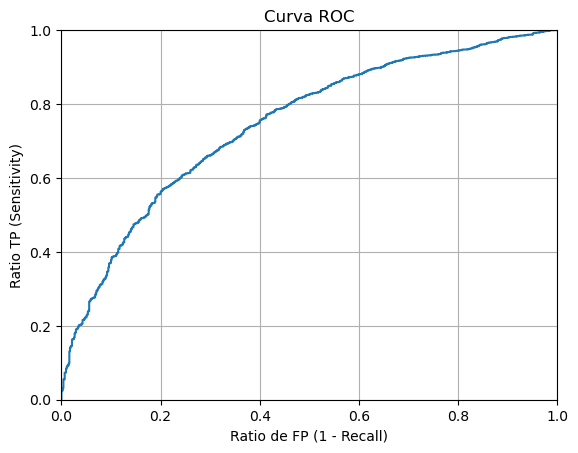

In [207]:
y_pred_prob_Mlp = final_Mlp.predict_proba(X_test_pca)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_Mlp)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC')
plt.xlabel('Ratio de FP (1 - Recall)')
plt.ylabel('Ratio TP (Sensitivity)')
plt.grid(True)
plt.show()

In [208]:
thresholds

array([       inf, 0.99999992, 0.96794146, ..., 0.19869326, 0.19383376,
       0.15203112])

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

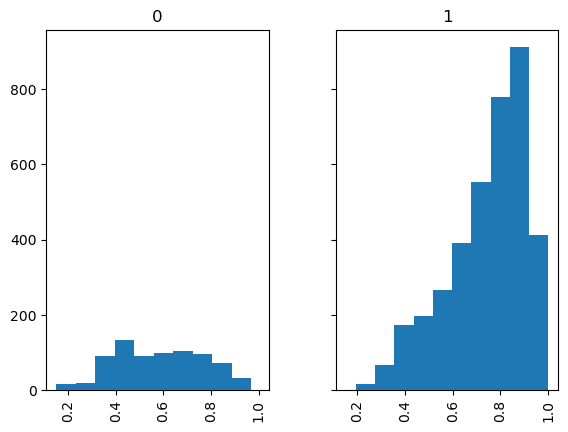

In [209]:
dprob = pd.DataFrame(data = {'probability':y_pred_prob_Mlp, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

In [210]:
op_thres_Mlp = 0.4

evaluate_threshold(op_thres_Mlp)

Sensitivity: 0.950066401062417
Recall: 0.17600000000000005


In [211]:
probs_Mlp_opt = final_Mlp.predict_proba(X_test_pca)[:, 1]  
pred_thres_Mlp_opt = (probs_Mlp_opt >= op_thres_Mlp).astype(int) 

In [212]:
print(confusion_matrix(expected_Mlp_opt, pred_thres_Mlp_opt))

[[ 131  619]
 [ 188 3577]]


In [213]:
print(classification_report(expected_Mlp_opt, pred_thres_Mlp_opt))

              precision    recall  f1-score   support

           0       0.41      0.17      0.25       750
           1       0.85      0.95      0.90      3765

    accuracy                           0.82      4515
   macro avg       0.63      0.56      0.57      4515
weighted avg       0.78      0.82      0.79      4515



Se obtiene la misma accuracy aunque mejora la *f1 score* en los 0s.

Se calcula la AUC score.

In [216]:
print(roc_auc_score(expected_Mlp_opt, predicted_Mlp_opt))

0.6360849933598938


También ha tenido una pequeña mejora, pero sigue en el mismo intervalo. Es decir, sigue siendo un modelo *D*.

#### - Curva de pérdidas y scores de validación

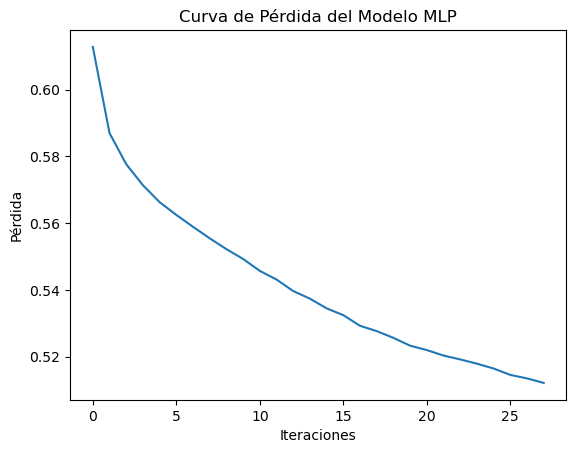

In [219]:
loss_values = final_Mlp.loss_curve_

plt.plot(loss_values)
plt.title('Curva de Pérdida del Modelo MLP')
plt.xlabel('Iteraciones')
plt.ylabel('Pérdida')
plt.show()

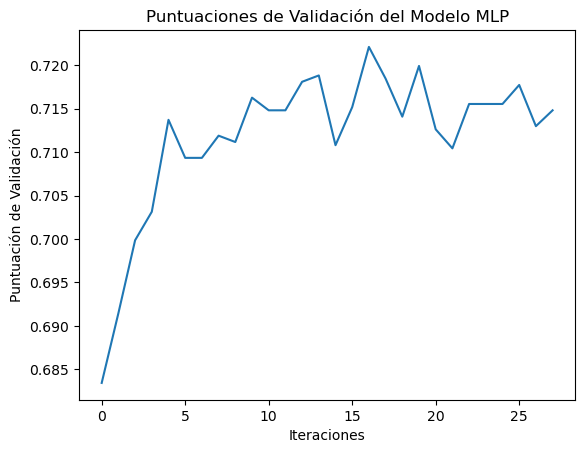

In [220]:
validation_scores = final_Mlp.validation_scores_

plt.plot(validation_scores)
plt.title('Puntuaciones de Validación del Modelo MLP')
plt.xlabel('Iteraciones')
plt.ylabel('Puntuación de Validación')
plt.show()

Observamos que la curva sigue la tendencia descendente, en cambio los scores de validación son muy oscilantes y realizan muy pocas iteraciones antes de producirse el *early_stop*.

### 6.3.9 Conclusiones

A continuación se muestra los resultados de los modelos optimizados y sin optimizar. Cabe recalcar que se probaron otros cuatro conjuntos de parametros en la mayoria de los casos, pero se acabó considerando absurdo porque mejoraba o empeoraba 0.01 en diversos valores

Caso X: accuracy - f1 score 0s - aux score - accuracy y f1 score 0s (threshold)

Caso 1: 
* Normal:      0.77 - 0.36 - 0.616 - 0.75 y 0,38 (0.6)
* Optimizado:  0.71 - 0.40 - 0.661 - 0.75 y 0.40 (0.4)

Caso 2: 
* Normal:      0.76 - 0.36 - 0.615 - 0.73 y 0,36 (0.6)
* Optimizado:  0.71 - 0.42 - 0.678 - 0.75 y 0.41 (0.4)

Caso 3:
* Normal:      0.69 - 0.41 - 0.668 - 0.73 y 0,41 (0.4)
* Optimizado:  0.73 - 0.42 - 0.678 - 0.79 y 0.39 (0.4)

Caso 4: 
* Normal:      0.69 - 0.38 - 0.646 - 0.72 y 0,38 (0.4)
* Optimizado:  0.72 - 0.40 - 0.655 - 0.78 y 0.39 (0.4)

Caso 5: 
* Normal:      0.75 - 0.39 - 0.643 - 0.72 y 0,39 (0.6)
* Optimizado:  0.77 - 0.41 - 0.657 - 0.81 y 0.38 (0.4)

Caso 6: 
* Normal:      0.75 - 0.36 - 0.616 - 0.73 y 0,37 (0.6)
* Optimizado:  0.81 - 0.40 - 0.636 - 0.76 y 0.43 (0.6)

Caso 3-2 (undersampling = 0.6): 
* Normal:      0.69 - 0.36 - 0.621 - 0.71 y 0,36 (0.4)
* Optimizado:  0.78 - 0.42 - 0.655 - 0.75 y 0.43 (0.55)

Caso 4-2 (undersampling = 0.6):
* Normal:      0.79 - 0.39 - 0.640 - 0.77 y 0,37 (0.4)
* Optimizado:  0.76 - 0.42 - 0.664 - 0.81 y 0.37 (0.4)

Caso 5-2 (undersampling = 0.6 y oversampling = 0.8): 
* Normal:      0.68 - 0.35 - 0.618 - 0.70 y 0,35 (0.4)
* Optimizado:  0.74 - 0.44 - 0.688 - 0.79 y 0.43 (0.4)

Caso 6-2 (undersampling = 0.6 y oversampling = 0.8): 
* Normal:      0.71 - 0.40 - 0.658 - 0.75 y 0,39 (0.4)
* Optimizado:  0.74 - 0.43 - 0.682 - 0.79 y 0.41 (0.4)

Se observa que para este modelo todos son valores muy similares. Por ello se probará primero a la hora de subirlo con el caso mejor (el sexto) pero también se realizarán pruebas sobre Kaggle con el resto.

## 6.4 Clasificador KNN

### 6.3.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [229]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 6

Hiperparametros base para cada caso.

In [231]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.8
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.25
    strategy_over = 0.5
    neighbors = 5

Se estandarizan los datos en función del caso.

In [233]:
X_scaled, prep = standard_data(case, X_train)

Se muestrean los datos en función del caso.

In [235]:
X_resampled, y_resampled = resample_data(case, X_scaled, y_train, strategy_under, strategy_over, neighbors)

Se reducen las dimensionalidades mediante un *PCA*.

In [237]:
pca = PCA()
X_pca_full = pca.fit_transform(X_resampled)

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
n_comp = np.argmax(cumulative_variance_ratio >= 0.95) + 1
X_pca = X_pca_full[:, :n_comp]

Al igual que se ha realizado distintos preprocesados al entrenamiento, hay que realizarlos al conjunto de test para obtener resultados coherentes.

No es necesario realizar las tecnicas de muestreo ya que eso son técnicas para balancear nuestro conjunto de entrenamiento. Solamente es necesario realizar la misma estandarización de las características y aplicar la misma reducción de dimensionalidad.

In [239]:
X_test_scaled = prep.transform(X_test)
X_test_pca_full = pca.transform(X_test_scaled)
X_test_pca = X_test_pca_full[:, :n_comp]

### 6.3.2 Definicion

Definimos el modelo básico.

In [242]:
model_KNN = KNeighborsClassifier()

### 6.3.3 Entrenamiento y evaluacion

Entrenamos el modelo y comprobamos su exactitud.

In [245]:
model_KNN.fit(X_pca, y_resampled)

predicted_KNN = model_KNN.predict(X_test_pca)
expected_KNN = y_test

In [246]:
accuracy_score(expected_KNN, predicted_KNN)

0.7375415282392026

### 6.3.4 Null accuracy

Nuestra exactitud es de 0.6801, la cual es peor que la *null accuracy*, es decir, ahora mismo no tenemos un buen modelo ya que se predecirían un mayor número de resultados en el caso de siempre predecir la clase mayoritaria.

### 6.3.5 Matriz de confusion y F-score

Se muestra la matriz de confusión y el informe de clasificación.

In [251]:
print(confusion_matrix(expected_KNN, predicted_KNN))

[[ 333  417]
 [ 768 2997]]


In [252]:
print(classification_report(expected_KNN, predicted_KNN))

              precision    recall  f1-score   support

           0       0.30      0.44      0.36       750
           1       0.88      0.80      0.83      3765

    accuracy                           0.74      4515
   macro avg       0.59      0.62      0.60      4515
weighted avg       0.78      0.74      0.76      4515



Se observa lo que hemos estado comentando durante todo el documento, tenemos un f1-score del 0.78 para los 1s mientras que estamos obteniendo un 0.39 para los 0s.

### 6.3.6 ROC y AUC

Evaluamos la ROC-AUC score. Para ello representamos primero la curva de ROC.

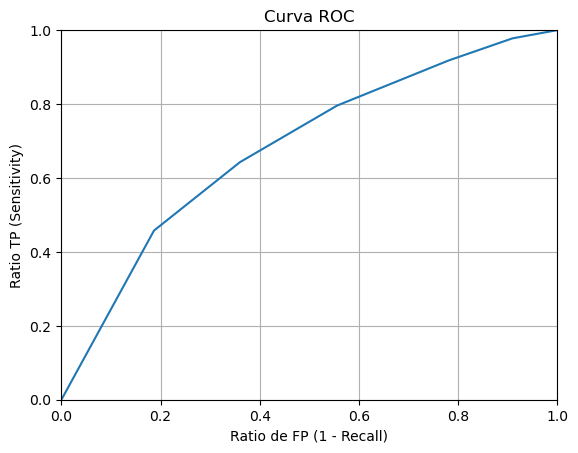

In [256]:
y_pred_prob_KNN = model_KNN.predict_proba(X_test_pca)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_KNN)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC')
plt.xlabel('Ratio de FP (1 - Recall)')
plt.ylabel('Ratio TP (Sensitivity)')
plt.grid(True)
plt.show()

Y mostramos sus thresholds.

In [258]:
thresholds

array([inf, 1. , 0.8, 0.6, 0.4, 0.2, 0. ])

La siguiente gráfica muestra las probabilidades de predicción en función de los umbrales.

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

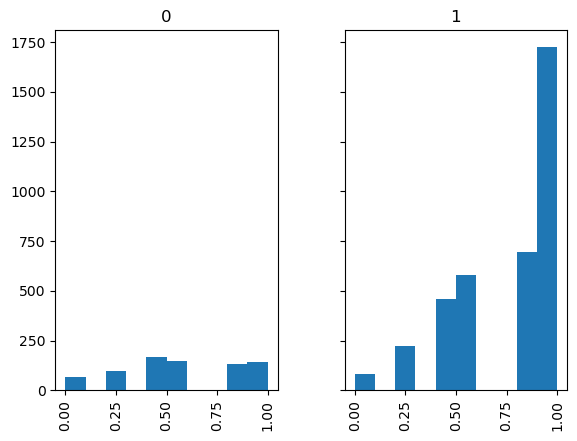

In [260]:
dprob = pd.DataFrame(data = {'probability':y_pred_prob_KNN, 'actual':y_test})
dprob.probability.hist(by=dprob.actual, sharex=True, sharey=True)

Se muestra unos resultados muy balanceados en el 0s excepto cuando su threshold es 1, mientras que en el caso de los 1s mantiene una tendencia ascendente.

In [262]:
best_thres_KNN = 0.5

evaluate_threshold(best_thres_KNN)

Sensitivity: 0.7960159362549801
Recall: 0.44399999999999995


Con este valor se obtienen los siguientes resultados. Primero se recalculan las predicciones.

In [264]:
probs_KNN = model_KNN.predict_proba(X_test_pca)[:, 1]  
pred_thres_KNN = (probs_KNN >= best_thres_KNN).astype(int) 

Se evalua la matriz de confusión.

In [266]:
print(confusion_matrix(expected_KNN, pred_thres_KNN))

[[ 333  417]
 [ 768 2997]]


Y también se analiza el informe de la clasificación.

In [268]:
print(classification_report(expected_KNN, pred_thres_KNN))

              precision    recall  f1-score   support

           0       0.30      0.44      0.36       750
           1       0.88      0.80      0.83      3765

    accuracy                           0.74      4515
   macro avg       0.59      0.62      0.60      4515
weighted avg       0.78      0.74      0.76      4515



Como se puede observar no hay cambios respecto a no utilizar threshold, ya que nuestro mejor caso era con el umbral igual a 0.5, es decir, el valor por defecto.

Finalmente se calcula el valor de AUC.

In [271]:
print(roc_auc_score(expected_KNN, predicted_KNN))

0.62000796812749


Se ha obtenido un valor entre 0.6 y 0.7, es decir, el modelo se considerá como pobre o *D*.

### 6.3.7 Optimizacion

Antes de nada, observamos cuales son los parámetros de nuestro modelo.

In [275]:
model_KNN.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

Ahora seleccionamos los hiperparámetros a evaluar mediante un GridSearchCV. Como se evalua mediante un *cross validation*, siempre escogeremos los casos 3 o 4 de preprocesado para falsear menos los datos.

Estos hiperparámetros son:
* n_neighbors: representa el número de vecinos a considerar en el modelo KNN
* weights: define cómo se ponderan los vecinos al calcular la predicción.
* algorithm: define el algoritmo utilizado para encontrar los vecinos más cercanos
* p: representa el parámetro de la distancia de Minkowski.
* leaf_size: valores más bajos pueden hacer la búsqueda más precisa pero más lenta.
* metric: define la métrica de distancia utilizada

Se calcula el tiempo que ha tardado en minutos.

### 6.3.8 Entramiento y evaluacion con hiperparametros optimizados

#### - Definicion

Definimos los mejores parámetros (no se define con *grid_search.best_params_* para probar varias opciones de forma sencilla).

In [281]:
params_final_KNN = {
    "n_neighbors": 11, 
    "leaf_size": 30, 
    "metric": "minkowski", 
    "p": 1, 
    "weights": "uniform", 
    "algorithm": "auto"
}

Definimos el modelo desagregando el diccionario.

In [283]:
final_KNN = KNeighborsClassifier(**params_final_KNN)

#### - Entrenamiento y evaluacion

Entrenamos el modelo y realizamos la predicción.

In [286]:
final_KNN.fit(X_pca, y_resampled)

predicted_KNN_opt = final_KNN.predict(X_test_pca)
expected_KNN_opt = y_test

Evaluamos la metrica obtenida.

In [288]:
accuracy_score(expected_KNN_opt, predicted_KNN_opt)

0.7579180509413067

#### - Matriz de confusion y F-score

La matriz de confusión y el informe de clasificación también es muy similar.

In [291]:
print(confusion_matrix(expected_KNN_opt, predicted_KNN_opt))

[[ 333  417]
 [ 676 3089]]


In [292]:
print(classification_report(expected_KNN_opt, predicted_KNN_opt))

              precision    recall  f1-score   support

           0       0.33      0.44      0.38       750
           1       0.88      0.82      0.85      3765

    accuracy                           0.76      4515
   macro avg       0.61      0.63      0.61      4515
weighted avg       0.79      0.76      0.77      4515



#### - ROC y AUC

Cómo se ha visto antes el mejor threshold será 0.5, así que no se realiza este apartado.

### 6.3.9 Conclusiones

A continuación se muestra los resultados de los modelos optimizados y sin optimizar. Cabe recalcar que se probaron otros cuatro conjuntos de hiperparámetros para la mayoria de los casos de preprocesado, pero se acabó considerando absurdo porque mejoraba o empeoraba 0.01 en diversos valores.

Caso 1 : 

              precision    recall  f1-score   support

           0       0.27      0.64      0.38       750
           1       0.90      0.65      0.76      3765

    accuracy                           0.65      4515

Caso 2 : 

              precision    recall  f1-score   support

           0       0.27      0.59      0.37       750
           1       0.89      0.69      0.78      3765

    accuracy                           0.67      4515

Caso 3 : 

              precision    recall  f1-score   support

           0       0.30      0.66      0.41       750
           1       0.91      0.69      0.79      3765

    accuracy                           0.69      4515

Caso 4 : 

              precision    recall  f1-score   support

           0       0.31      0.66      0.42       750
           1       0.91      0.71      0.80      3765

    accuracy                           0.70      4515

Caso 5 : 

              precision    recall  f1-score   support

           0       0.31      0.47      0.38       750
           1       0.88      0.80      0.84      3765

    accuracy                           0.74      4515

Caso 6 : 

              precision    recall  f1-score   support

           0       0.33      0.45      0.38       750
           1       0.88      0.82      0.85      3765

    accuracy                           0.76      

En nuestro caso el mejor caso es el 6 o el 4 si nos fijamos en el f1 score de los 0s.

# 7. Exportar CSV

## 7.1 Clasificador Random Forest

### 7.1.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [303]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 4

Hiperparametros base para cada caso.

In [305]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.6
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.25
    strategy_over = 0.5
    neighbors = 5

Se estandarizan los datos en función del caso.

In [307]:
X_scaled_final, prep_final = standard_data(case, X_train_final)

Se muestrean los datos en función del caso.

In [309]:
X_resampled_final, y_resampled_final = resample_data(case, X_scaled_final, y_train_final, strategy_under, strategy_over, neighbors)

Se reducen las dimensionalidades mediante un *PCA*.

In [311]:
pca_final = PCA()
X_pca_full_final = pca_final.fit_transform(X_resampled_final)

cumulative_variance_ratio_final = np.cumsum(pca_final.explained_variance_ratio_)
n_comp_final = np.argmax(cumulative_variance_ratio_final >= 0.95) + 1
X_pca_final = X_pca_full_final[:, :n_comp_final]

Se preprocesa el conjunto de test.

In [313]:
X_test_scaled_final = prep_final.transform(X_test_final)
X_test_pca_full_final = pca_final.transform(X_test_scaled_final)
X_test_pca_final = X_test_pca_full_final[:, :n_comp_final]

### 7.1.2 Entrenamiento y exportacion de las predicciones

Se entrena con los nuevos valores de train y test, y se modifica el umbral de probabilidades. En un principio, el valor del umbral era el de la variable *op_thres_Random*, pero se decidió finalmente que el valor del umbral fueran valores numéricos para que fuera más sencillo hacer diversas pruebas en Kaggle.

In [316]:
final_Forest.fit(X_pca_final, y_resampled_final)

probs_For_final = final_Forest.predict_proba(X_test_pca_final)[:, 1]  
pred_thres_For_final = (probs_For_final >= 0.5).astype(int) 

Se crea un *dataframe* con las predicciones obtenidas con su correspondiente *id*.

In [318]:
df_accept_Random = pd.DataFrame(pred_thres_For_final, columns=['Accept'])

In [319]:
df_id = df_test['id'].reset_index(drop=True)

In [320]:
df_final_Random = pd.concat([df_id, df_accept_Random], axis=1)

Mostramos los resultados obtenidos para tener una idea de la proporción de 1s y 0s de Kaggle.

In [322]:
df_final_Random['Accept'].value_counts()

Accept
1    1992
0    1292
Name: count, dtype: int64

Se transforma el *dataframe* a un archivo *CSV*.

In [324]:
df_final_Random.to_csv('./submit/random.csv', index=False)

## 7.2 Clasificador MLP

### 7.2.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [328]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 6

Hiperparametros base para cada caso.

In [330]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.6
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.25
    strategy_over = 0.7
    neighbors = 5

Se estandarizan los datos en función del caso.

In [332]:
X_scaled_final, prep_final = standard_data(case, X_train_final)

Se muestrean los datos en función del caso.

In [334]:
X_resampled_final, y_resampled_final = resample_data(case, X_scaled_final, y_train_final, strategy_under, strategy_over, neighbors)

Se reducen las dimensionalidades mediante un *PCA*.

In [336]:
pca_final = PCA()
X_pca_full_final = pca_final.fit_transform(X_resampled_final)

cumulative_variance_ratio_final = np.cumsum(pca_final.explained_variance_ratio_)
n_comp_final = np.argmax(cumulative_variance_ratio_final >= 0.95) + 1
X_pca_final = X_pca_full_final[:, :n_comp_final]

Se preprocesa el conjunto de test.

In [338]:
X_test_scaled_final = prep_final.transform(X_test_final)
X_test_pca_full_final = pca_final.transform(X_test_scaled_final)
X_test_pca_final = X_test_pca_full_final[:, :n_comp_final]

### 7.2.2 Entrenamiento y exportacion de las predicciones

Se entrena con los nuevos valores de train y test, y se modifica el umbral de probabilidades.

In [341]:
final_Mlp.fit(X_pca_final, y_resampled_final)

probs_Mlp_final = final_Mlp.predict_proba(X_test_pca_final)[:, 1]  
pred_thres_Mlp_final = (probs_Mlp_final >= 0.55).astype(int) 

Se crea un *dataframe* con las predicciones obtenidas con su correspondiente *id*.

In [343]:
df_accept_Mlp = pd.DataFrame(pred_thres_Mlp_final, columns=['Accept'])

In [344]:
df_id = df_test['id'].reset_index(drop=True)

In [345]:
df_final_Mlp = pd.concat([df_id, df_accept_Mlp], axis=1)

Mostramos los resultados obtenidos para tener una idea de la proporción de 1s y 0s de Kaggle.

In [347]:
df_final_Mlp['Accept'].value_counts()

Accept
1    1808
0    1476
Name: count, dtype: int64

Comprobamos la curva de pérdidas y los scores de validación.

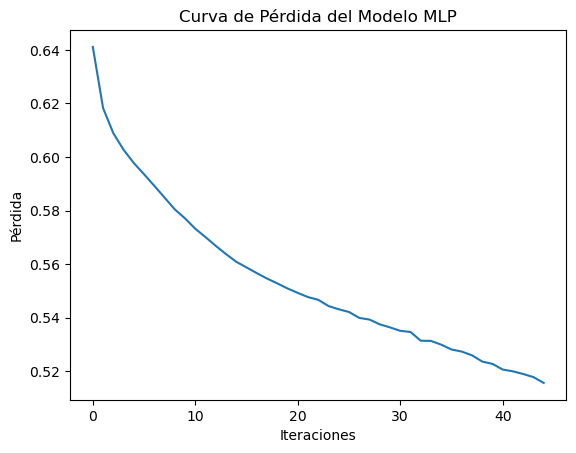

In [349]:
loss_values = final_Mlp.loss_curve_

plt.plot(loss_values)
plt.title('Curva de Pérdida del Modelo MLP')
plt.xlabel('Iteraciones')
plt.ylabel('Pérdida')
plt.show()

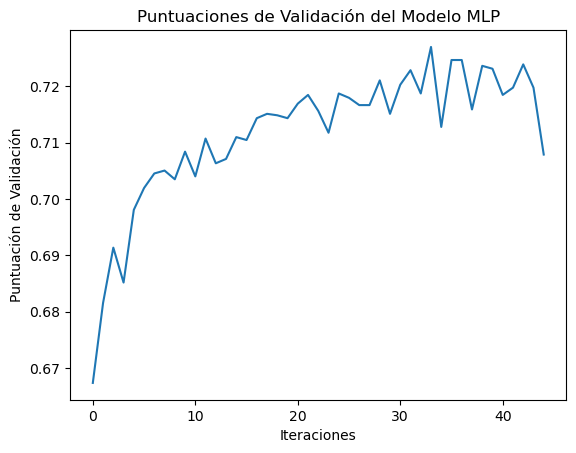

In [350]:
validation_scores = final_Mlp.validation_scores_

plt.plot(validation_scores)
plt.title('Puntuaciones de Validación del Modelo MLP')
plt.xlabel('Iteraciones')
plt.ylabel('Puntuación de Validación')
plt.show()

Se transforma el *dataframe* a un archivo *CSV*.

In [352]:
df_final_Mlp.to_csv('./submit/mlp.csv', index=False)

## 7.3 Clasificador KNN

### 7.3.1 Seleccion del caso de preprocesado

Seleccion del caso de preprocesado.

In [356]:
# case - caso de preprocesado seleccionado, valores posibles: 1, 2, 3, 4, 5, 6
case = 4

Hiperparametros base para cada caso.

In [358]:
if case in {1, 2}:
    strategy_under = 0
    strategy_over = 1
    neighbors = 5
    
elif case in {3, 4}:
    strategy_under = 0.6
    strategy_over = 0
    neighbors = 0
    
elif case in {5, 6}:
    strategy_under = 0.25
    strategy_over = 0.5
    neighbors = 5

Se estandarizan los datos en función del caso.

In [360]:
X_scaled_final, prep_final = standard_data(case, X_train_final)

Se muestrean los datos en función del caso.

In [362]:
X_resampled_final, y_resampled_final = resample_data(case, X_scaled_final, y_train_final, strategy_under, strategy_over, neighbors)

Se reducen las dimensionalidades mediante un *PCA*.

In [364]:
pca_final = PCA()
X_pca_full_final = pca_final.fit_transform(X_resampled_final)

cumulative_variance_ratio_final = np.cumsum(pca_final.explained_variance_ratio_)
n_comp_final = np.argmax(cumulative_variance_ratio_final >= 0.95) + 1
X_pca_final = X_pca_full_final[:, :n_comp_final]

Se preprocesa el conjunto de test.

In [366]:
X_test_scaled_final = prep_final.transform(X_test_final)
X_test_pca_full_final = pca_final.transform(X_test_scaled_final)
X_test_pca_final = X_test_pca_full_final[:, :n_comp_final]

### 7.3.2 Entrenamiento y exportacion de las predicciones

Se entrena con los nuevos valores de train y test, y se modifica el umbral de probabilidades. En un principio, el valor del umbral era el de la variable *op_thres_Random*, pero se decidió finalmente que el valor del umbral fueran valores numéricos para que fuera más sencillo hacer diversas pruebas en Kaggle.

In [369]:
final_KNN.fit(X_pca_final, y_resampled_final)

probs_KNN_final = final_KNN.predict_proba(X_test_pca_final)[:, 1]  
pred_thres_KNN_final = (probs_KNN_final >= 0.5).astype(int) 

Se crea un *dataframe* con las predicciones obtenidas con su correspondiente *id*.

In [371]:
df_accept_KNN = pd.DataFrame(pred_thres_KNN_final, columns=['Accept'])

In [372]:
df_id = df_test['id'].reset_index(drop=True)

In [373]:
df_final_KNN = pd.concat([df_id, df_accept_KNN], axis=1)

Mostramos los resultados obtenidos para tener una idea de la proporción de 1s y 0s de Kaggle.

In [375]:
df_final_KNN['Accept'].value_counts()

Accept
1    2074
0    1210
Name: count, dtype: int64

Se transforma el *dataframe* a un archivo *CSV*.

In [377]:
df_final_Random.to_csv('./submit/knn.csv', index=False)